# Stock Price Prediction - Petrobras S.A.

The aim of this project is to build machine learning models in order to predict future stock prices for the brazilian company Petrobras S.A. For this, we use three tree-based machine learning models: regression trees, random forest and XGBoost.

Authors: 

*Caio Lopes de Souza* 

*Gabriel Rodrigues Palma*

*Silvio Sandoval Zocchi*

## Packages used in this project

In [1]:
# data manipulation 
import numpy as np
import pandas as pd

# data extraction 
from yahooquery import Ticker 

# data visualization
import matplotlib.pyplot as plt

# machine learning models
from sklearn.ensemble import RandomForestRegressor 
from xgboost import XGBRegressor 

# models performance metrics
from sklearn.metrics import mean_squared_error

## Functions used in this project

In [2]:
def open_data(path):
    '''read a csv file and returns a dataframe'''
    
    dataframe = pd.read_csv(path, encoding='latin-1')
    
    return dataframe

In [3]:
def correct_data(dataframe, old_column, new_columns, split_point):
    '''correct data formatting'''
    
    dataframe[new_columns] = dataframe[old_column].str.split(split_point, expand=True)
    dataframe = dataframe.drop(old_column, axis=1)
    
    return dataframe

In [4]:
def correct_multindex(data, level, column_exclusion): 
    '''transform a multindex dataframe into a dataframe with only one index'''
    
    data = data.reset_index(level=level)
    data = data.drop(column_exclusion, axis=1)
    
    return data

In [5]:
def convert_datatypes(dataframe, column_to_numeric, column_to_date):
    '''change the datatype of two columns from object to numeric and date'''

    dataframe[column_to_numeric] = pd.to_numeric(dataframe[column_to_numeric])
    dataframe[column_to_date] = pd.to_datetime(dataframe[column_to_date], format='%d/%m/%Y')
    
    return dataframe

In [6]:
def line_plot(dataset, column_list, x_label, y_label, title):
    '''plot a standardized line plot for a chosen variable from a dataset'''
    color_list = ['blue', 'red', 'green']
    
    fig, ax = plt.subplots(figsize=(8, 3))
    for column in column_list: 
        dataset[column].plot(color=color_list[column_list.index(column)], ax=ax)
            
        ax.set_label(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(title)
            
        plt.tight_layout()

## Data gathering and manipulation

###  Stock Prices

#### Data Gathering

In [7]:
stock = Ticker("PETR4.SA")
stock = stock.history(period="max")

In [8]:
stock_price = stock['close']
stock_price = pd.DataFrame(stock_price, columns =['close'])

#### Data manipulation

In [9]:
stock_price = correct_multindex(stock_price, level=[0, 1], column_exclusion = 'symbol')

In [10]:
stock_price = stock_price.drop(stock_price.tail(1).index)

In [11]:
stock_price = convert_datatypes(stock_price, column_to_numeric = 'close', column_to_date='date')

In [12]:
stock_price = stock_price.rename(columns={"date": "Date", "close": "Close_price"})

In [13]:
stock_price

,Date,Close_price
0,2000-01-03,5.875000
1,2000-01-04,5.550000
2,2000-01-05,5.494000
3,2000-01-06,5.475000
4,2000-01-07,5.500000
...,...,...
5916,2023-07-21,29.680000
5917,2023-07-24,30.299999
5918,2023-07-25,31.000000
5919,2023-07-26,31.000000


### IPCA

IPCA is the most famous brazilian customer price index. It's the officialy inflation index used by the brazilian government. Data updates about the index are monthly released by the IBGE, the brazilian institute of geography and statistics. More information can be found in this [link](https://www.ibge.gov.br/estatisticas/economicas/precos-e-custos/9256-indice-nacional-de-precos-ao-consumidor-amplo.html).

#### Data Gathering

In [14]:
ipca = open_data(r"C:\Users\caiol\Petrobras S.A\Dados_input\IPCA_Mensal(1980-2023)_v2.csv")

#### Data manipulation

In [15]:
ipca = correct_data(ipca, 'Data;Valor', ['Date', 'IPCA'], ';')

In [16]:
ipca = convert_datatypes(ipca, column_to_numeric = 'IPCA', column_to_date = 'Date')

In [17]:
ipca.dtypes

Date    datetime64[ns]
IPCA           float64
dtype: object

In [18]:
ipca.head()

,Date,IPCA
0,1980-01-01,6.62
1,1980-02-01,4.62
2,1980-03-01,6.04
3,1980-04-01,5.29
4,1980-05-01,5.70


### Exchange rate 

Here, we use the commercial free float exchange rates between the brazilian Real and the american Dollar. It shows the a daly data between 11/28/1984 and 06/30/2023. The brazilian Central Bank computes this rate through the refference rate "PTAX".

* PTAX Methodology: http://www.ipeadata.gov.br/doc/EE042_A_taxa_de_cambio_de_referencia_Ptax.pdf

* Link for the data source: https://www3.bcb.gov.br/sgspub/consultarvalores/consultarValoresSeries.do?method=getPagina 

#### Data gathering

In [19]:
exchange_rate = open_data(r"C:\Users\caiol\Petrobras S.A\Dados_input\Câmbio_diário(1984-2023)_v2.csv")

#### Data manipulation 

In [20]:
exchange_rate = correct_data(exchange_rate, 'Data;Cambio', ['Date', 'Exchange_rate'], ';')

In [21]:
exchange_rate

,Date,Exchange_rate
0,02/01/1990,11.524
1,03/01/1990,11.751
2,04/01/1990,11.983
3,05/01/1990,12.209
4,08/01/1990,12.44
...,...,...
8392,26/06/2023,4.769
8393,27/06/2023,4.79
8394,28/06/2023,4.856
8395,29/06/2023,4.858


In [22]:
exchange_rate = convert_datatypes(exchange_rate, column_to_numeric = 'Exchange_rate', column_to_date = 'Date')

In [23]:
exchange_rate.head()

,Date,Exchange_rate
0,1990-01-02,11.524
1,1990-01-03,11.751
2,1990-01-04,11.983
3,1990-01-05,12.209
4,1990-01-08,12.440


### Interest Rates (SELIC)

The most basic and important interest rate in Brazil is the SELIC rate, which is the rediscount rate for the brazilian economy and has an influence over all other interest rates in the country.

#### Data gathering

In [24]:
selic = open_data(r"C:\Users\caiol\Petrobras S.A\Dados_input\SELIC(2000-2023).csv")

#### Data manipulation

In [25]:
selic = correct_data(selic, 'Data;Selic', ['Date', 'Selic'], ';')

In [26]:
selic = convert_datatypes(selic, column_to_numeric = 'Selic', column_to_date = 'Date')

In [27]:
selic.head()

,Date,Selic
0,2000-01-01,19.0
1,2000-01-02,19.0
2,2000-01-03,19.0
3,2000-01-04,19.0
4,2000-01-05,19.0


### Oil Price

#### Data gathering

In [28]:
oil = open_data(r"C:\Users\caiol\Petrobras S.A\Dados_input\petróleo_preço(1987-2023).csv")

#### Data manipulation

In [29]:
oil = correct_data(oil, 'Data;Preço do petróleo brent(dólares/barril)', ['Date', 'Oil_price'], ';')

In [30]:
oil = convert_datatypes(oil, column_to_numeric = 'Oil_price', column_to_date = 'Date')

In [31]:
oil.head()

,Date,Oil_price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


### Merging all together

In [32]:
data_list = [stock_price, exchange_rate, selic, oil]

In [33]:
dataset = stock_price.merge(exchange_rate, on='Date')
dataset = dataset.merge(selic, on='Date')
dataset = dataset.merge(oil, on='Date')

In [34]:
dataset.index = dataset['Date']

dataset = dataset.drop('Date', axis=1)

In [35]:
dataset.head()

,Close_price,Exchange_rate,Selic,Oil_price
Date,,,,
2000-01-04,5.550,1.833,19.0,23.95
2000-01-05,5.494,1.854,19.0,23.72
2000-01-06,5.475,1.845,19.0,23.55
2000-01-07,5.500,1.827,19.0,23.35
2000-01-10,5.613,1.815,19.0,22.77


### Exploratory Data Analysis

In [36]:
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 10
}

In [37]:
def line_plot(dataset, column_list, x_label, y_label, title):
    color_list = ['blue', 'red', 'green']
    
    fig, ax = plt.subplots(figsize=(8, 3))
    for column in column_list: 
        dataset[column].plot(color=color_list[column_list.index(column)], ax=ax)
            
        ax.set_label(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(title)
            
        plt.tight_layout()

#### Data Visualization

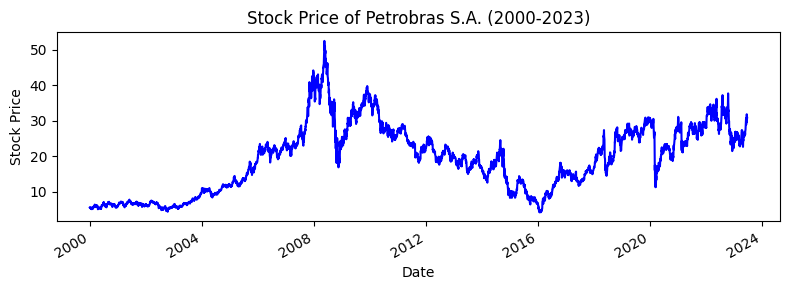

In [38]:
line_plot(dataset, column_list = ['Close_price'], x_label='Time (days)', y_label='Stock Price',
          title = 'Stock Price of Petrobras S.A. (2000-2023)')

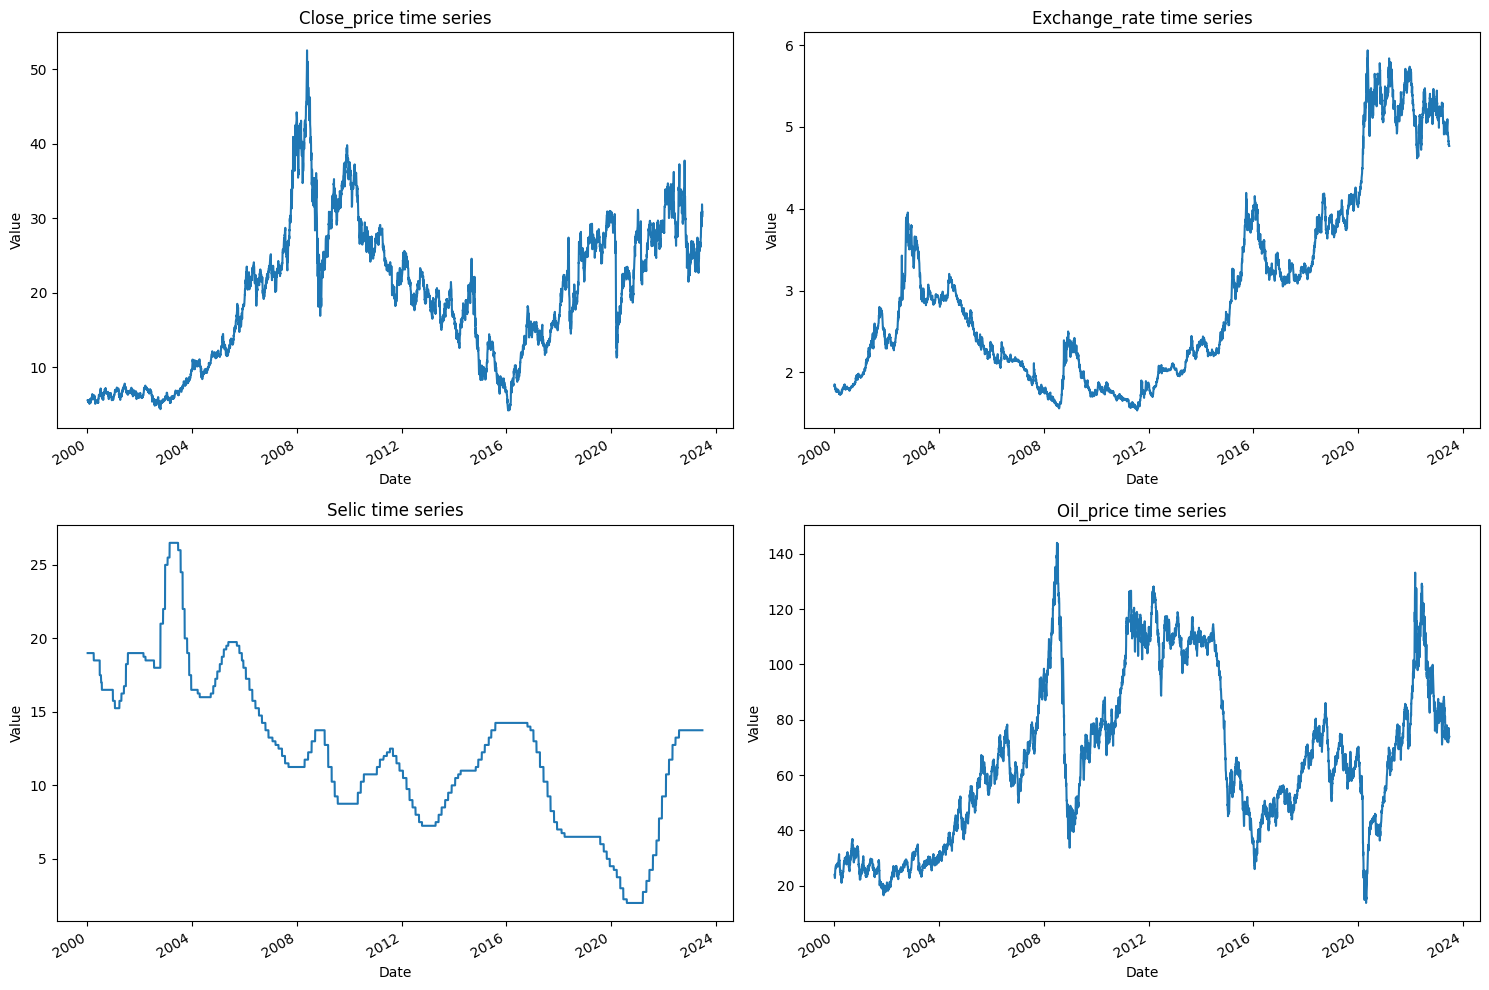

In [39]:
plt.figure(figsize=(15, 10))

for i, data in enumerate(dataset.columns, 1):
    plt.subplot(2, 2, i)
    dataset[data].plot()
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title(f"{data} time series")
plt.tight_layout()

### Training-test Split

In [40]:
def training_test_split(X, y, training_rate = 0.8):
    '''split a dataset into a training and test set for a chosen ratio'''
    X_train = X.iloc[:round(training_rate * len(X))]
    X_test = X.iloc[round(training_rate * len(X)):]
    y_train = y.iloc[:round(training_rate * len(y))]
    y_test = y.iloc[round(training_rate * len(y)):]
    
    return X_train, X_test, y_train, y_test

In [41]:
X = dataset.drop('Close_price', axis=1)
y = dataset['Close_price']

In [42]:
X_train, X_test, y_train, y_test = training_test_split(X, y)

### A naive model 

For a naive model, which will be used to compare the performance of the other models, we'll consider the value of the estimate for the response variable as being equal to the value of the response variable in the past day. In other words, $\hat{y}_t = y_{t-1}$

In [43]:
dataset['price_lag_1'] = dataset['Close_price'].shift(1)
dataset = dataset.drop(dataset.head(1).index, axis=0)

In [304]:
X_lag = dataset['price_lag_1']
y_lag = dataset['Close_price']

In [305]:
X_train_lag, X_test_lag, y_train_lag, y_test_lag = training_test_split(X_lag, y_lag)

In [306]:
mean_squared_error(X_test_lag, y_test_lag)

0.5753591371641674

In [307]:
dataset = dataset.drop('price_lag_1', axis=1)

In [308]:
y = dataset['Close_price']
X = dataset.drop('Close_price', axis=1)

In [309]:
X_train, X_test, y_train, y_test = training_test_split(X, y)

### Regression Tree

In [310]:
from sklearn.tree import DecisionTreeRegressor

In [311]:
reg_tree = DecisionTreeRegressor(random_state=42)

In [312]:
reg_tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [313]:
tree_predictions = reg_tree.predict(X_test)
tree_predictions = pd.Series(tree_predictions, index=X_test.index)

In [314]:
print(f"The MSE for the model is {mean_squared_error(y_test, tree_predictions)}")

The MSE for the model is 144.7040303486486


### Random Forest

In [315]:
rf_reg = RandomForestRegressor(max_depth = 10, random_state=42)

In [316]:
def fit_predict(X, y, model):
    
    predictions = np.array([])
    
    X_train, X_test, y_train, y_test = training_test_split(X, y)
    model.fit(X_train.values, y_train.values)
    
    for i in range(len(X_test)):
        predictions = np.append(predictions, (model.predict(X_test.iloc[i].values.reshape(1, -1))))
        
        X_train = pd.concat([X_train, X_test.iloc[i].to_frame().T])
        y_train = np.append(y_train, y_test.iloc[i].reshape(1, -1))
        
        y_train = pd.Series(y_train)
        
        model.fit(X_train.values, y_train.values)
        
    return predictions

In [317]:
X_train = pd.concat([X_train, X_test.iloc[0]])

In [319]:
predictions = fit_predict(X, y, rf_reg)

In [320]:
mean_squared_error(y_test, predictions)

3.8011742644127064

In [322]:
predictions = pd.Series(predictions, index=X_test.index)

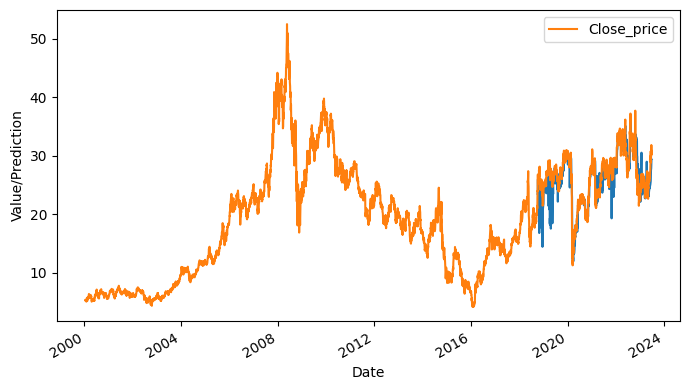

In [323]:
fig, ax = plt.subplots(figsize=(7, 4))

predictions.plot(ax=ax)

y.plot(ax=ax)

ax.legend()

ax.set_xlabel('Date')
ax.set_ylabel('Value/Prediction')

plt.tight_layout()

#### Fit

In [154]:
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

#### Predictions and MSE

In [155]:
rf_predictions = rf_reg.predict(X_test)
rf_predictions = pd.Series(rf_predictions, index=y_test.index)

In [161]:
print(f"The MSE for the model is {mean_squared_error(y_test, rf_predictions)}")

The MSE for the model is 136.19974936188817


#### Performance visualization

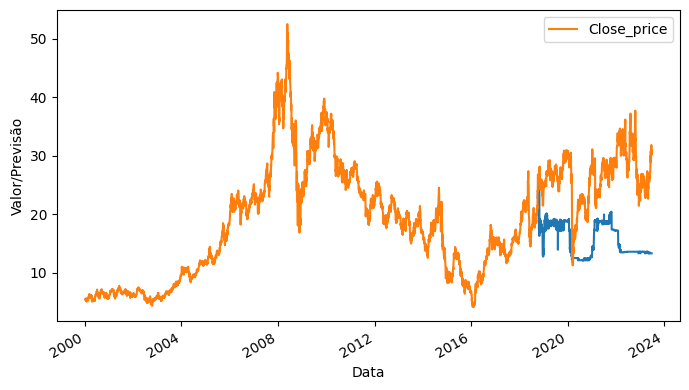

In [162]:
fig, ax = plt.subplots(figsize=(7, 4))

rf_predictions.plot(ax=ax)

y.plot(ax=ax)

ax.legend()

ax.set_xlabel('Data')
ax.set_ylabel('Valor/Previsão')

plt.tight_layout()

### XGBoost

In [163]:
xgb = XGBRegressor()

#### Fit

In [164]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### Predictions and MSE

In [165]:
xgb_predictions = xgb.predict(X_test)
xgb_predictions = pd.Series(xgb_predictions, index=X_test.index)

In [166]:
mean_squared_error(y_test, xgb_predictions)

127.55721552933633

#### Performance visualization

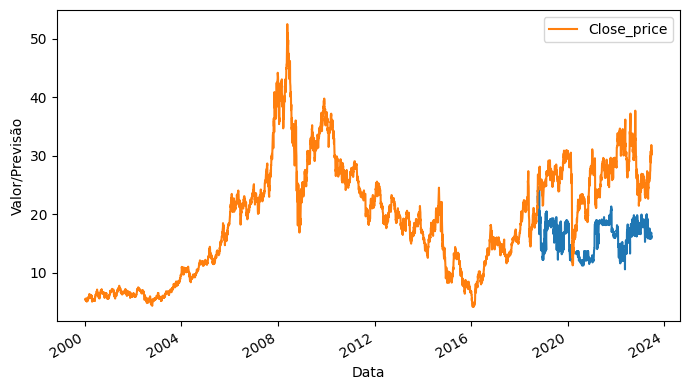

In [167]:
fig, ax = plt.subplots(figsize=(7, 4))

xgb_predictions.plot(ax=ax)

y.plot(ax=ax)

ax.legend()

ax.set_xlabel('Data')
ax.set_ylabel('Valor/Previsão')

plt.tight_layout()